Then this notebook demonstrates how to read and work with data from the tov_ET simulation. See: https://github.com/nds-org/jupyter-et/blob/master/tutorial-server/notebooks/CactusTutorial.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import aurel

First you need to tell aurel where you store your simulations directory, you can run the following to in the notebook, but update the path to your own.

In [2]:
import os
os.environ["SIMLOC"] = "/Users/rlm36AA/simulations/"

Alternatively, in your bashrc include:

`export SIMLOC="/path/to/simulations/"`

then after reloading the terminal, you can check this with

`echo $SIMLOC`

In [3]:
# this creates a dictionary with the content of the simulation's parameter file
param = aurel.parameters('tov_ET')
# define the FiniteDifference class for the base level grid of the simulation
fd = aurel.FiniteDifference(param)

4th order finite difference schemes are defined


aurel.read_data and aurel.AurelCore only work on 3D data, so to record 3D data, add the following to the tov_ET.par before running the simulation:

CarpetIOHDF5::out_every = 4096

CarpetIOHDF5::out_vars = "

 HydroBase::rho 

 ...and any other relevant variables

"

In [4]:
# this lists all the iterations available accross different refinement levels and restarts
aurel.iterations(param, skip_last = False)
# by default skip_last = True so that the last restart is skipped
# this is to avoid reading active files

 === restart 0
Reading /Users/rlm36AA/simulations/tov_ET/output-0000/tov_ET/gxx.file_0.h5
it = 0 -> 409600
rl = 0 at it = np.arange(0, 409600, 4096)
rl = 1 at it = np.arange(0, 409600, 4096)



Great, we can choose a couple of iterations and read in the simulation data

In [5]:
data = aurel.read_data(
    param, 
    ['rho', 'vel', 'press', 'w_lorentz', 'eps',
     'lapse', 'dtlapse', 'shift', 'dtshift', 'metric', 'curv',
     'ML_Ham', 'ML_Mom', 'trK'],
    # specify the fields to read, these have to be 3D outputs of the simulation
    it = np.arange(0, 409600, 4096),
    # specify the iterations to be read, default is [0]
    rl = 0,
    restart = 0,
    # specify the refinement level and restart number, default is 0 for both
    )
# the output is a dictionary with the iteration, simulation time, and each requested variables
print(data.keys())
print('it format: type {} and shape {}'.format(type(data['it']), np.shape(data['it'])))
print('rho0 format: type {} and shape {}'.format(type(data['rho0']), np.shape(data['rho0'])))
print('rho0[0] format: type {} and shape {}'.format(type(data['rho0'][0]), np.shape(data['rho0'][0])))
# note some variable names may be different to those called
# the new names will match the AurelCore naming convention
# rho0: rest-mass energy density

dict_keys(['it', 't', 'rho0', 'press', 'w_lorentz', 'eps', 'Ktrace', 'alpha', 'dtalpha', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'betax', 'betay', 'betaz', 'dtbetax', 'dtbetay', 'dtbetaz', 'velx', 'vely', 'velz', 'Hamiltonian', 'Momentumx', 'Momentumy', 'Momentumz'])
it format: type <class 'numpy.ndarray'> and shape (100,)
rho0 format: type <class 'list'> and shape (100, 12, 12, 12)
rho0[0] format: type <class 'numpy.ndarray'> and shape (12, 12, 12)


This data can directly be assessed and plotted

Text(0.5, 1.0, '$max(\\rho_0) / \\rho_0(0)$')

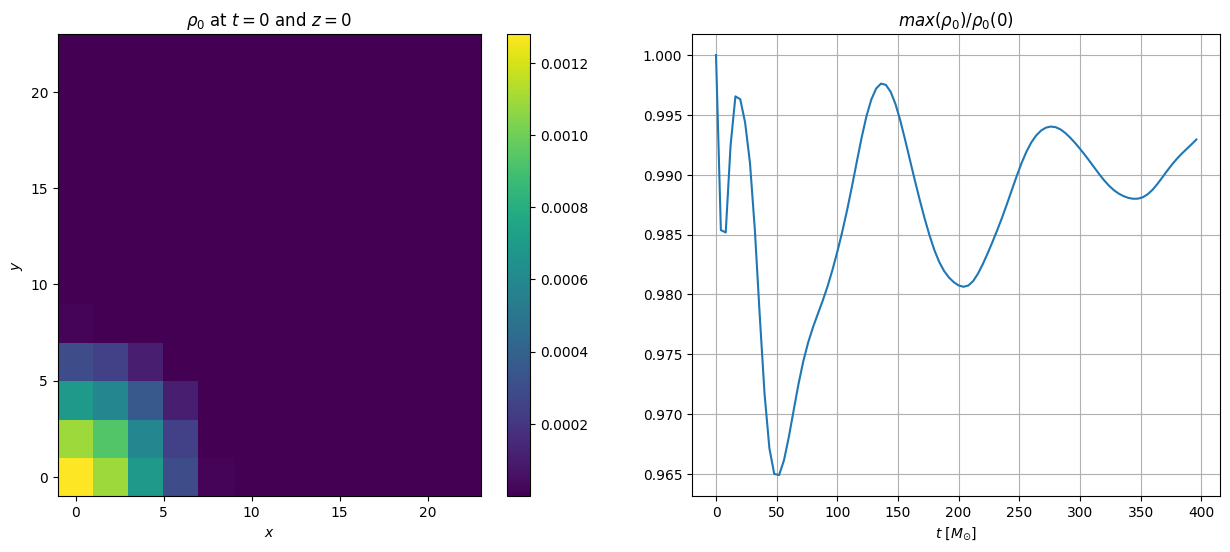

In [6]:
plt.figure(figsize=(15, 6))

# plot the first iteration
it_index = 0 # iteration index
iz = 0 # z slice index
plt.subplot(121)
plt.pcolor(fd.xarray, fd.yarray, data['rho0'][it_index][:,:,iz])
plt.colorbar()
plt.title(r'$\rho_0$ at $t=0$ and $z=0$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# get the maximum rest mass density at each iteration
rhomax = []
for it_index in range(len(data['it'])):
    rhomax += [np.max(data['rho0'][it_index])]
    if it_index == 0:
        rhoIN = rhomax[it_index]

# plot the maximum rest mass density as a function of time
plt.subplot(122)
plt.plot(data['t'], rhomax / rhoIN)
plt.grid()
plt.xlabel(r'$t$ [$M_{\odot}$]')
plt.title(r'$max(\rho_0) / \rho_0(0)$')

Then you can use AurelCore to calculate further quantities.

Define AurelCore and you can directly input the simulation data of the specific iteration with load_data

In [7]:
rel = aurel.AurelCore(fd)
it_index = 0
rel.load_data(data, it_index)

<IPython.core.display.Latex object>

Then you can access any variable listed in aurel.descriptions by calling AurelCore[variable_name].

To get this variable at each iteration you should loop over the it_index as is done below.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, 'max($\\gamma$)')

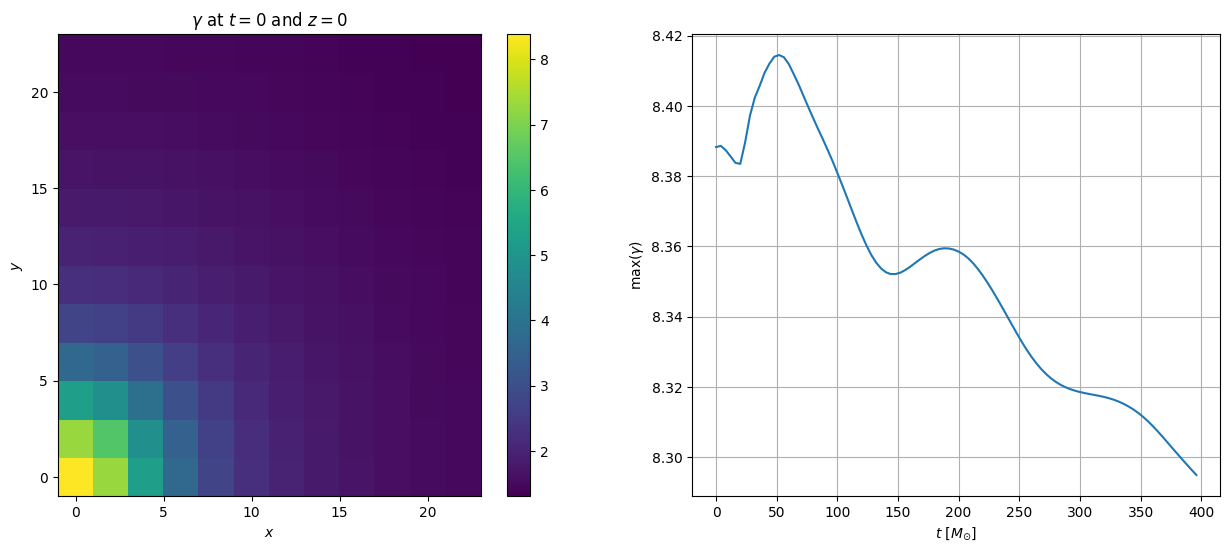

In [8]:
# calculating at the determinant of the spatial metric
variable = 'gammadet'
varstr = r'$\gamma$'

plt.figure(figsize=(15, 6))

# plot the first iteration
plt.subplot(121)
plt.pcolor(fd.xarray, fd.yarray, rel[variable][:,:,0])
plt.colorbar()
plt.title(varstr + r' at $t=0$ and $z=0$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# get the max value at each iteration
# turn verbose off in the loop
maxR = []
for it_index in range(len(data['it'])):
    rel = aurel.AurelCore(fd, verbose=False)
    rel.load_data(data, it_index)
    maxR += [np.max(rel[variable])]
    del rel

# plot the maximum rest mass density as a function of time
plt.subplot(122)
plt.plot(data['t'], maxR)
plt.grid()
plt.xlabel(r'$t$ [$M_{\odot}$]')
plt.ylabel('max(' + varstr + ')')

## Want to work with a refined level?

In [9]:
# then delete the previous finitedifference class (or name the new one something else)
del fd
# now we will look at the following refinement level
rl = 1

# load the data from that level
data = aurel.read_data(
    param, 
    ['rho', 'metric'],
    it = np.arange(0, 409600, 4096),
    rl = rl)

# relevant parameters of this grid level
Nx, Ny, Nz = np.shape(data['rho0'][0])
grid = {
    'Nx': Nx, 'Ny': Ny, 'Nz': Nz,
    'xmin': 0.0, 'ymin': 0.0, 'zmin': 0.0,
    'dx': param['dx']/2**rl,
    'dy': param['dx']/2**rl,
    'dz': param['dx']/2**rl,
}
fd = aurel.FiniteDifference(grid)

4th order finite difference schemes are defined


Text(0.5, 1.0, '$max(\\rho_0) / \\rho_0(0)$')

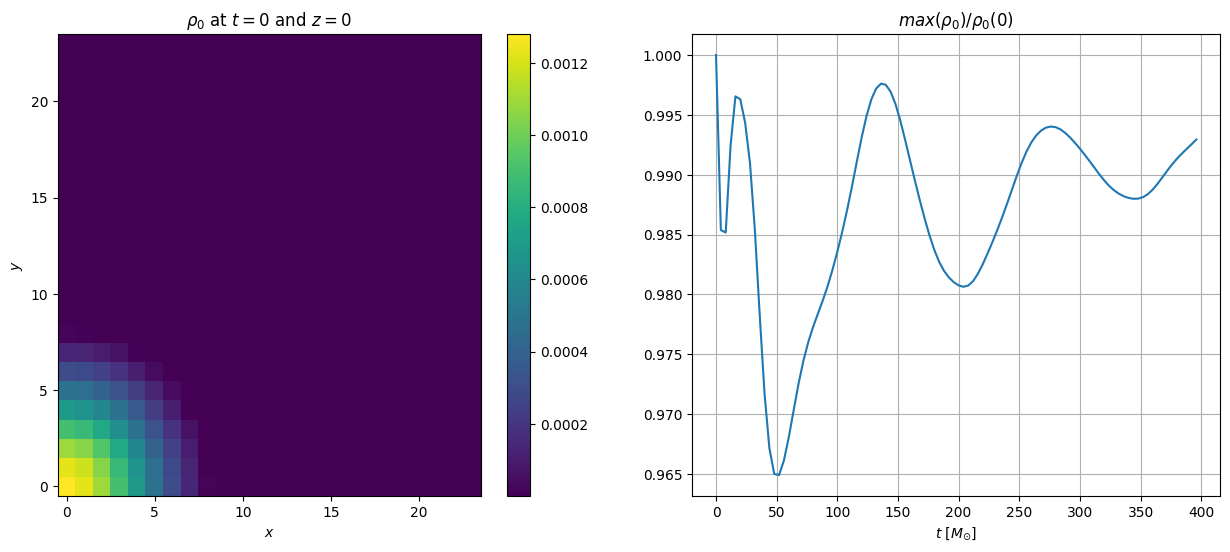

In [10]:
plt.figure(figsize=(15, 6))

# plot the first iteration
it_index = 0 # iteration index
iz = 0 # z slice index
plt.subplot(121)
plt.pcolor(fd.xarray, fd.yarray, data['rho0'][it_index][:,:,iz])
plt.colorbar()
plt.title(r'$\rho_0$ at $t=0$ and $z=0$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# get the maximum rest mass density at each iteration
rhomax = []
for it_index in range(len(data['it'])):
    rhomax += [np.max(data['rho0'][it_index])]
    if it_index == 0:
        rhoIN = rhomax[it_index]

# plot the maximum rest mass density as a function of time
plt.subplot(122)
plt.plot(data['t'], rhomax / rhoIN)
plt.grid()
plt.xlabel(r'$t$ [$M_{\odot}$]')
plt.title(r'$max(\rho_0) / \rho_0(0)$')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, 'max($\\gamma$)')

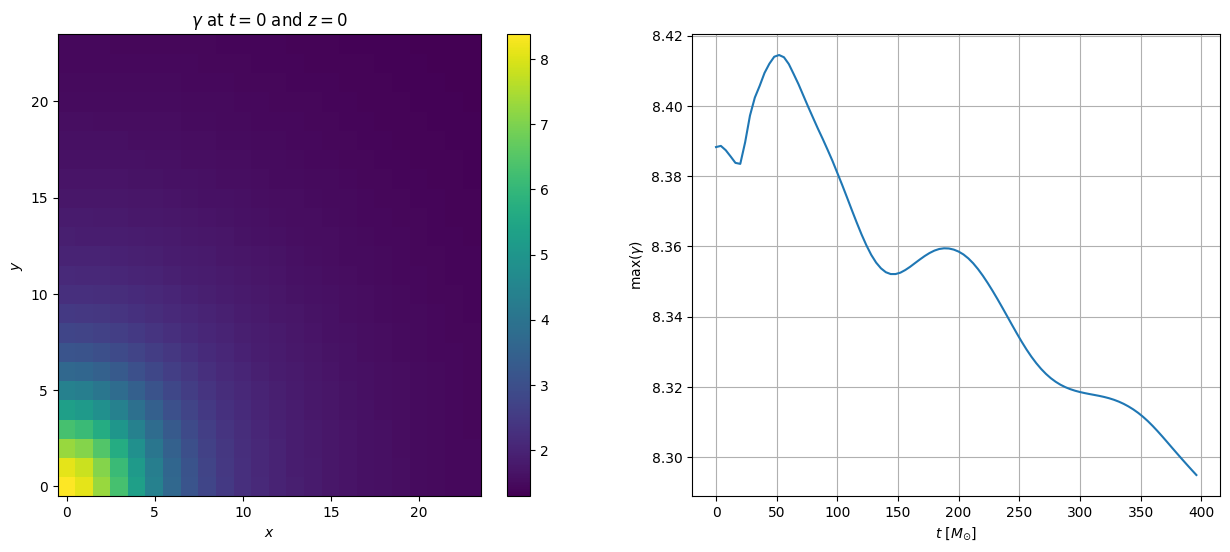

In [11]:
# calculating at the determinant of the spatial metric
variable = 'gammadet'
varstr = r'$\gamma$'

plt.figure(figsize=(15, 6))

rel = aurel.AurelCore(fd)
it_index = 0
rel.load_data(data, it_index)

# plot the first iteration
plt.subplot(121)
plt.pcolor(fd.xarray, fd.yarray, rel[variable][:,:,0])
plt.colorbar()
plt.title(varstr + r' at $t=0$ and $z=0$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# get the max value at each iteration
# turn verbose off in the loop
maxR = []
for it_index in range(len(data['it'])):
    rel = aurel.AurelCore(fd, verbose=False)
    rel.load_data(data, it_index)
    maxR += [np.max(rel[variable])]
    del rel

# plot the maximum rest mass density as a function of time
plt.subplot(122)
plt.plot(data['t'], maxR)
plt.grid()
plt.xlabel(r'$t$ [$M_{\odot}$]')
plt.ylabel('max(' + varstr + ')')